# 2022-03-02 • Factor out conntest & eval code

## Setup

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

## Params & sim

Short warm-up run. Get compilation out of the way.

In [5]:
p0 = params
@set! p0.sim.input    = previous_N_30_input
@set! p0.sim.duration = 1 * minutes;

In [6]:
@time sim(p0.sim);

  3.444051 seconds (6.22 M allocations: 358.928 MiB, 3.57% gc time, 98.33% compilation time)


In [7]:
p = params
@set! p.sim.input                  = realistic_N_6600_input
@set! p.sim.duration               = 10 * minutes
@set! p.sim.synapses.Δg_multiplier = 0.08
dumps(p)

ExperimentParams
  rngseed: 22022022
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 100000
    rngseed: 22022022
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 5200
      N_inh: 1300
      N_conn: 6500
      N: 6600
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      Δg_exc: 4.0e-10
      Δg_inh: 1.6e-9
      Δg_multiplier: 0.08
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: 10.0
      spike_SNR_dB: 20.0
      spike_height: 0.095
      σ_noise: 0.0095
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    rngseed: 22022022
  evaluation: EvaluationParams
    num_tested_neurons_p

In [8]:
t, v, input_spikes = @time sim(p.sim);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
  6.321853 seconds (6.35 M allocations: 449.585 MiB, 6.21% gc time, 53.71% compilation time)


In [9]:
num_spikes = length.(input_spikes)

ComponentVector{Int64}(conn = (exc = [4, 19, 14, 17, 20, 10, 5, 17, 17, 19  …  15, 22, 15, 11, 14, 18, 17, 19, 4, 19], inh = [14, 9, 8, 3, 14, 11, 13, 25, 18, 19  …  8, 18, 22, 8, 13, 20, 20, 5, 12, 24]), unconn = [13, 7, 19, 24, 10, 12, 14, 18, 16, 21  …  9, 18, 12, 14, 15, 7, 18, 26, 13, 16])

## Plot

In [10]:
import PyPlot

In [11]:
using Sciplotlib

[ Info: Precompiling Sciplotlib [61be95e5-9550-4d5f-a203-92a5acbc3116]


In [12]:
""" tzoom = [200ms, 600ms] e.g. """
function plotsig(t, sig, tzoom = nothing; ax = nothing, clip_on=false, kw...)
    isnothing(tzoom) && (tzoom = t[[1, end]])
    izoom = first(tzoom) .≤ t .≤ last(tzoom)
    if isnothing(ax)
        plot(t[izoom], sig[izoom]; clip_on, kw...)
    else
        plot(t[izoom], sig[izoom], ax; clip_on, kw...)
    end
end;

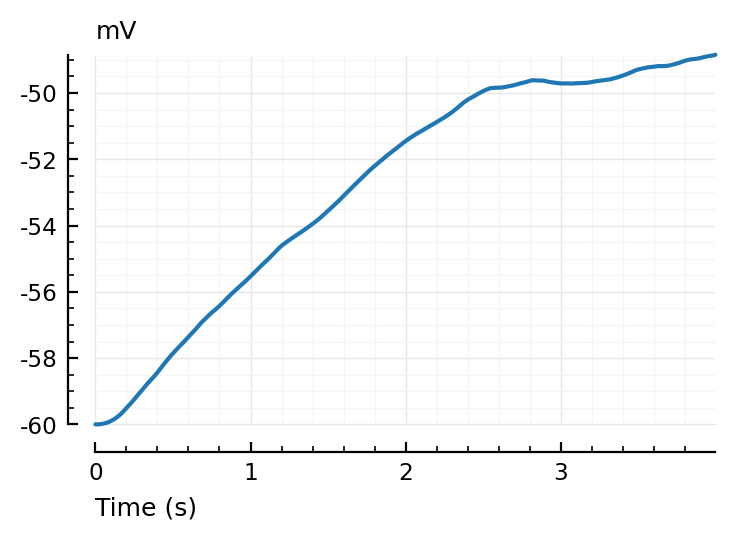

In [13]:
plotsig(t, v/mV, [0s, 4seconds], xlabel="Time (s)", hylabel="mV");

## Imaging noise

In [ ]:
izh_params = cortical_RS

imaging_spike_SNR  #=::Float64=#  = 20
spike_height       #=::Float64=#  = izh_params.v_peak - izh_params.vr
σ_noise            #=::Float64=#  = spike_height / imaging_spike_SNR;

In [ ]:
noise = randn(length(v)) * σ_noise
vimsig = v + noise;

In [ ]:
ax = plotsig(t, vimsig / mV, [200ms,1200ms], xlabel="Time (s)", hylabel="mV", alpha=0.7);
plotsig(t, v / mV, [200ms,1200ms], xlabel="Time (s)", hylabel="mV"; ax);

## Window

In [ ]:
window_duration    #=::Float64=#  = 100 * ms;

In [ ]:
const Δt = p.Δt
const win_size = round(Int, window_duration / Δt)
const t_win = linspace(zero(window_duration), window_duration, win_size)

function calc_STA(presynaptic_spikes)
    STA = zeros(eltype(vimsig), win_size)
    win_starts = round.(Int, presynaptic_spikes / Δt)
    num_wins = 0
    for a in win_starts
        b = a + win_size - 1
        if b ≤ lastindex(vimsig)
            STA .+= @view vimsig[a:b]
            num_wins += 1
        end
    end
    STA ./= num_wins
    return STA
end;

In [ ]:
function plotSTA(presynspikes)
    STA = calc_STA(presynspikes)
    plot(t_win/ms, STA/mV)
end;

In [ ]:
presynspikes = input_spikes.conn.exc[44]
plotSTA(presynspikes);

## Test connection

In [ ]:
num_shuffles       #=::Int    =#  = 100;

In [ ]:
to_ISIs(spiketimes) = [first(spiketimes); diff(spiketimes)]  # copying
to_spiketimes!(ISIs) = cumsum!(ISIs, ISIs)                   # in place

(presynspikes |> to_ISIs |> to_spiketimes!) ≈ presynspikes   # test

In [ ]:
shuffle_ISIs(spiketimes) = to_spiketimes!(shuffle!(to_ISIs(spiketimes)));

In [ ]:
test_statistic(spiketimes) = spiketimes |> calc_STA |> mean;

Note difference with 2021: there it was peak-to-peak (max - min). Here it is mean.

In [ ]:
function test_connection(presynspikes)
    real_t = test_statistic(presynspikes)
    shuffled_t = Vector{typeof(real_t)}(undef, num_shuffles)
    for i in eachindex(shuffled_t)
        shuffled_t[i] = test_statistic(shuffle_ISIs(presynspikes))
    end
    N_shuffled_larger = count(shuffled_t .> real_t)
    return if N_shuffled_larger == 0
        p_value = 1 / num_shuffles
    else
        p_value = N_shuffled_larger / num_shuffles
    end
end;

## Results

In [ ]:
resetrng!(20220222);

In [ ]:
num_trains = 40
println("Average p(shuffled trains with higher STA mean).")
println("(N = $(num_trains) input spike trains per category)")

p_exc    = Float64[]
p_inh    = Float64[]
p_unconn = Float64[]

for (groupname, spiketrains, pvals) in (
        ("excitatory",    input_spikes.conn.exc, p_exc),
        ("inhibitory",    input_spikes.conn.inh, p_inh),
        ("unconnected",   input_spikes.unconn, p_unconn),
    )
    for spiketrain in spiketrains[1:num_trains]
        push!(pvals, test_connection(spiketrain))
        print("."); flush(stdout)
    end
    @printf "%12s: %.3g\n" groupname mean(pvals)
end

In [ ]:
fig, ax = plt.subplots(figsize=(3.4,3))
function plotdot(y, x, c, jitter=0.28)
    N = length(y)
    x -= 0.35
    plot(x*ones(N) + (rand(N).-0.5)*jitter, y, "o", color=c, ms=4.2, markerfacecolor="none", clip_on=false)
    plot(x+0.35, mean(y), "k.", ms=10)
end
plotdot(p_exc,    1, "C2"); ax.text(1-0.16, -0.1, "excitatory"; color="C2", ha="center")
plotdot(p_unconn, 2, "C0"); ax.text(2-0.16, -0.1, "unconnected"; color="C0", ha="center")
plotdot(p_inh,    3, "C1"); ax.text(3-0.16, -0.1, "inhibitory"; color="C1", ha="center")
ax.boxplot([p_exc, p_unconn, p_inh], widths=0.2, medianprops=Dict("color"=>"black"))
set(ax, xlim=(0.33, 3.3), ylim=(0, 1), xaxis=:off)
hylabel(ax, L"p(\, \mathrm{shuffled\ \overline{STA}} \ > \ \mathrm{actual\ \overline{STA}}\, )"; dy=10);

Proportion of shuffled spike trains for which `mean(STA)` is higher than the unshuffled spike train.

Excitatory (green), unconnected (blue), and inhibitory (orange) input neurons.


10-minute simulation with a total of 6500 connected input neurons.